In [8]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_dir = '/data/yuchen_data/Stereo_seq/All_Figures/Figure3_v2/'

df = pd.read_csv(f'{data_dir}/All_cell.count.txt', index_col=0, sep='\t')
df_meta = pd.read_csv(f'{data_dir}/All_cell.metadata.txt', index_col=0, sep='\t')
dic_group = dict(zip(df_meta.index, df_meta['Final_group']))

genes_positive = ['TCF4', 'CD40', 'SLAMF1', 'IRF8', 'TNFRSF13C', 'STAT3', 'IL6', 'MEF2C', 'BACH2', 'EZH2', 'FOXO1', 'CCND2', 'IL4R', 'LYN', 'IL10', 'CBL', 'CXCR3', 'IRF4', 'MAPK1', 'E2F1', 'SPIB', 'TCF3', 'MTOR', 'BCL6', 'TLR4', 'UHRF1']

bins_naiveb = df_meta.index[df_meta['CellSubType'] == 'Bnaive']
df_naiveb = df[bins_naiveb]
df_naiveb = df_naiveb.T
df_naiveb['Final_group'] = df_naiveb.index.map(dic_group)

df_rst = df_naiveb.groupby('Final_group').agg('mean')[genes_positive].reindex(['Pre_Conforming', 'Post_Conforming', 'Pre_Deviating', 'Post_Deviating'])
df_rst = df_rst.loc[:, df_rst.sum() > 0]
df_rst = (df_rst - df_rst.mean()) / df_rst.std()
df_rst = df_rst.T



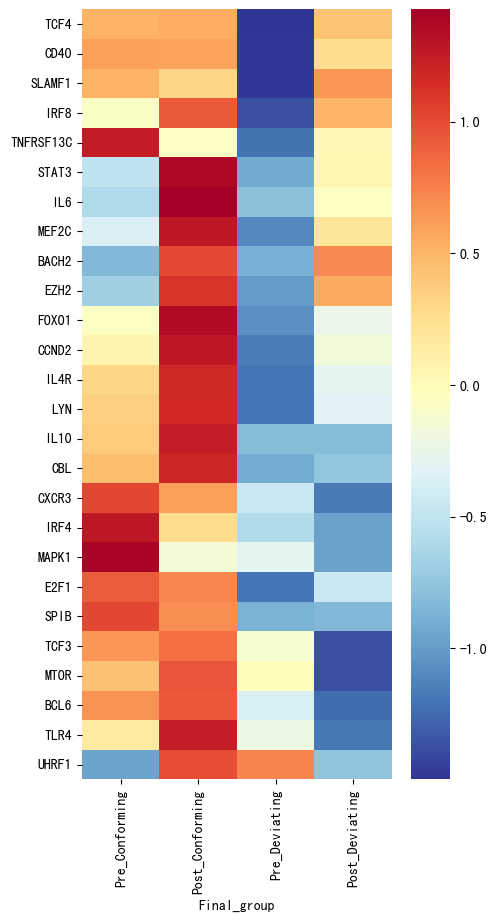

In [6]:
plt.figure(figsize=(5, 10))
sns.heatmap(df_rst, annot=False, cmap='RdYlBu_r',  yticklabels=True)
plt.show()

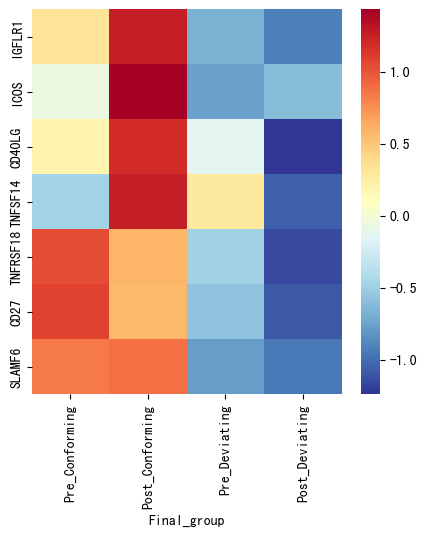

In [9]:
def get_tls_bin_neighbors(df, n_neighbors=9):
    df_coordinate = df[['row', 'col']].values
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(df_coordinate)
    distance_mat, neighbours_mat = knn.kneighbors(df_coordinate)
    neighbours_mat = pd.DataFrame(neighbours_mat, index=df.index, columns=['Self'] + [f'Neibor_{x}' for x in range(n_neighbors-1)])
    return neighbours_mat

dic_bin_group = dict(zip(df_meta.index, df_meta['Final_group']))
dic_bin_tls = dict(zip(df_meta.index, df_meta['TLS']))
dic_tls_group = {}
for idx, row in df_meta.iterrows():
    cur_tls = row['TLS']
    group = row['Final_group']
    if cur_tls not in dic_tls_group:
        dic_tls_group[cur_tls] = group

all_tls = df_meta['TLS'].unique()

##### 筛选位于Bnaive周围的Tfh
used_tfh = []
for tls in all_tls:
    df_cur = df_meta[df_meta['TLS'] == tls]
    bin_tfh = df_cur.index[df_cur['CellSubType'] == 'Tfh']
    if len(bin_tfh) > 0:
        neighbours_mat = get_tls_bin_neighbors(df_cur, n_neighbors=9)
        for bin in bin_tfh:
            neibor_bins = df_cur.index[neighbours_mat.loc[bin, ].values]
            if 'Bnaive' in set(df_cur.reindex(neibor_bins)['CellSubType']):
                used_tfh.append(bin)



used_genes = ['IGFLR1', 'ICOS', 'CD40LG', 'TNFSF14', 'TNFRSF18', 'CD27', 'SLAMF6']

# df_gs = pd.read_csv('/data1/yuchen/BGI_liver_cancer/4.FinalAnalysis/0.Data/17.geneSets/T细胞基因集-re.csv', sep=',')
# used_genes = df_gs['Co-stimulatory molecules'][~df_gs['Co-stimulatory molecules'].isna()].values
# used_genes = np.concatenate((used_genes, np.array(['IL4'], dtype=object)))
###### 比较count
df_tfh = df[used_tfh]
df_tfh = df_tfh.T
df_tfh['Final_group'] = df_tfh.index.map(dic_bin_group)
df_tmp = df_tfh.groupby('Final_group').agg('mean')[used_genes]
df_tmp = df_tmp.reindex(['Pre_Conforming', 'Post_Conforming', 'Pre_Deviating', 'Post_Deviating'])

# 画热图
df_tmp = (df_tmp - df_tmp.mean()) / df_tmp.std()
df_tmp = df_tmp.T
plt.figure(figsize=(5, 5))
sns.heatmap(df_tmp, annot=False, cmap='RdYlBu_r', yticklabels=True)
plt.show()

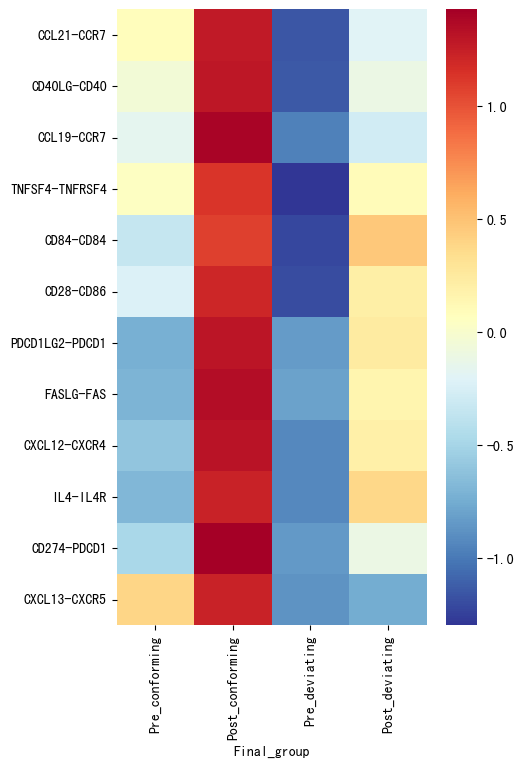

In [22]:
df_merge = pd.read_csv(f'{data_dir}/LRintensity.inTLS.txt', index_col=0, sep='\t')

plot_order = ['Pre_conforming', 'Post_conforming', 'Pre_deviating', 'Post_deviating']
plot_lrs = ['CCL21-CCR7', 'CD40LG-CD40', 'CCL19-CCR7', 'TNFSF4-TNFRSF4', 'CD84-CD84', 'CD28-CD86', 'PDCD1LG2-PDCD1', 'FASLG-FAS', 'CXCL12-CXCR4', 'IL4-IL4R', 'CD274-PDCD1','CXCL13-CXCR5']
ct = 'Bnaive'
df_cur = df_merge[df_merge['CellSubType'] == ct]
df_cur = df_cur.drop(['SpotLight_Anno', 'CellSubType', 'TLS', 'TLS_group', 'Cohort'], axis=1)
df_plot = df_cur.groupby('Final_group').agg('mean').reindex(plot_order)
df_plot = (df_plot - df_plot.mean()) / df_plot.std()
df_plot = df_plot.T

plt.figure(figsize=(5, 8))
sns.heatmap(df_plot.reindex(plot_lrs), cmap="RdYlBu_r", yticklabels=True)
plt.show()